# Machine Learning for Insurance Claim and Potential Customer Prediction

## Table of Contents <a id='back'></a>

* [1. Introduction](#intro)
* [2. Initiation](#init)
* [3. Data Overview](#overview)
* [4. Exploratory Data Analysis](#eda)
* [5. Task 1 - Grouping Similar Clients](#similar)
* [6. Task 2 - Potential Insurance Claim Prediction](#class)
* [7. Task 3 - Insurance Benefit Regression](#reg)
* [8. Task 4 - Data Obfuscation](#mask)
* [9. Proof That Linear Regression Can Work With Obfuscated Data](#mask1)
* [10. Testing Linear Regression With Obfuscated Data](#mask2)
* [11. General Conclusion](#end)
* [12. Appendix](#index)

## 1. Introduction

### 1.1. Project Description

The insurance company called "Sure Tomorrow" wants to address some issues with the help of machine learning. You have been asked to evaluate the possibilities.

### 1.2. Objectives

The objectives for this research are:
1. Find clients who are similar to a specific client's criteria. This task will facilitate the company's marketing efforts.
2. Predict whether new clients are likely to file an insurance claim. Is the model's prediction better than that of the dummy model?
3. Predict the potential amount of insurance claims that new clients may receive using a linear regression model.
4. Protect clients' personal data without compromising the model from the previous tasks.

### 1.3. Data Description

Dataset includes:
* Features: gender, age, salary, and number of family members of the insured individual.
* Target: the amount of claims received by the insured individual over the past five years.

### 1.4. Methodology

Steps followed:
1. Data Overview
2. Exploratory Data Analysis
3. Grouping Similar Customers
4. Potential Insurance Claim Prediction
5. Insurance Benefit Regression
6. Data Obfuscation
7. Proof That Linear Regression Can Work With Obfuscated Data
8. Testing Linear Regression With Obfuscated Data
9. Conclusion

## 2. Initiation <a id='init'></a>

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as st
from scipy.spatial import distance

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split

from IPython.display import display
import warnings

In [2]:
np.random.seed(0)
state=np.random.RandomState(0)
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('datasets/insurance_us.csv')

## 3. Data Overview <a id='overview'></a>

In [4]:
df.sample(5)

,Gender,Age,Salary,Family members,Insurance benefits
398,0,30.0,37700.0,1,0
3833,1,29.0,43700.0,1,0
4836,1,38.0,43600.0,1,0
4572,1,27.0,43400.0,1,0
636,0,26.0,36100.0,1,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              5000 non-null   int64  
 1   Age                 5000 non-null   float64
 2   Salary              5000 non-null   float64
 3   Family members      5000 non-null   int64  
 4   Insurance benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [7]:
df['gender'] = df['gender'].astype('int8')
df['age'] = df['age'].astype('int8')
df['income'] = df['income'].astype('int32')
df['family_members'] = df['family_members'].astype('int8')
df['insurance_benefits'] = df['insurance_benefits'].astype('int8')

In [8]:
df.dtypes

gender                 int8
age                    int8
income                int32
family_members         int8
insurance_benefits     int8
dtype: object

In [9]:
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.359400,1.194200,0.148000
std,0.500049,8.440807,9900.082063,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


All the data is in the right datatypes and reasonable ranges.

## 4. Exploratory Data Analysis <a id='eda'></a>

Let's quickly review the dataset, is there any clustering by looking at the pairplot?

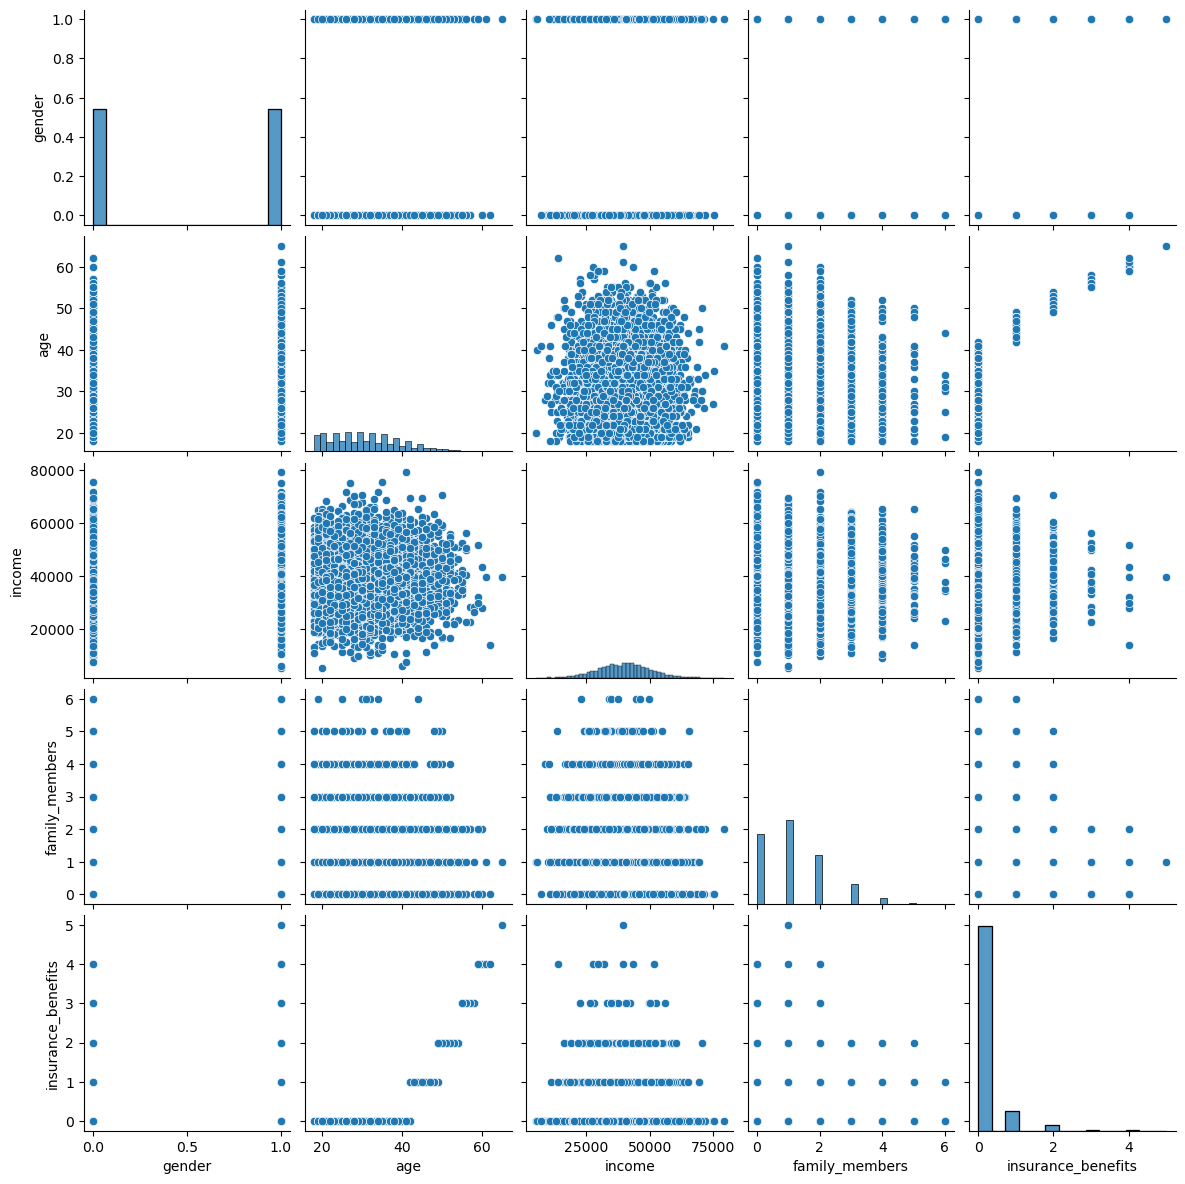

In [10]:
g = sns.pairplot(df, kind='scatter', diag_kind='hist')
g.fig.set_size_inches(12, 12)

Alright, it seems a bit challenging to identify clear clusters considering the difficulty in combining multiple variables simultaneously (for analyzing multivariate distributions). However, that's where LA (Linear Algebra) and ML (Machine Learning) come in handy.

To gain a clearer understanding, we will try to create a plot between the variables `age`, `income`, and `insurance` benefits.

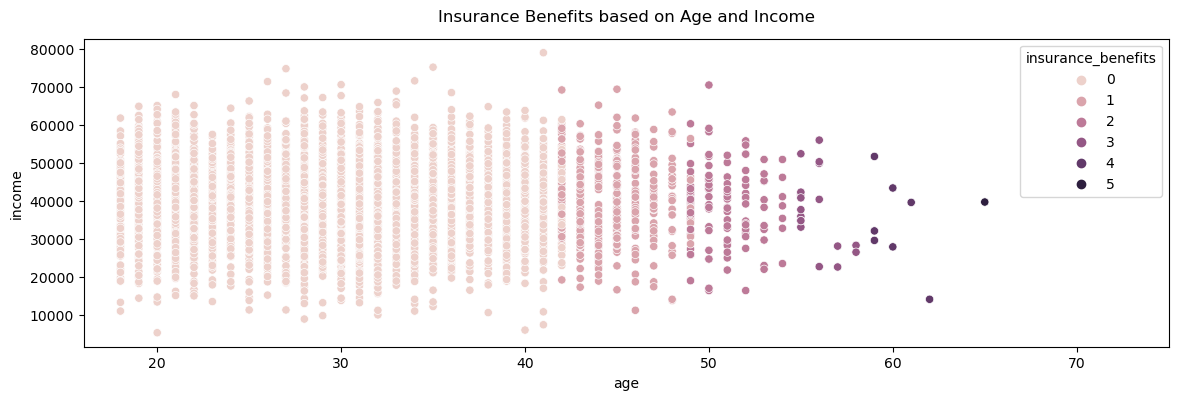

In [11]:
plt.figure(figsize=(14,4))
sns.scatterplot(data=df,x='age',y='income',hue='insurance_benefits')
plt.title('Insurance Benefits based on Age and Income',y=1.03)
plt.xlim([16,75])
plt.show()

It appears that as a person gets older, the insurance benefits they receive tend to increase regardless of their income.

## 5. Task 1 - Grouping Similar Clients <a id='similar'></a>

In ML programming languages, it is important to develop procedures that can determine the k-nearest neighbors (objects) to a particular object based on the distance between objects.

You may want to review the following lessons (chapter -> lesson):
* Vector Distance -> Euclidean Distance
* Vector Distance -> Manhattan Distance

To accomplish this task, we can try several distance metrics.

Create a function that displays the k-nearest neighbors for the nth object based on a specific distance metric. The amount of insurance claims received does not need to be considered in this task.

Test the algorithm for four combinations of two cases:
* Scaling
  * Unscaled data
  * Data scaled with MaxAbsScaler
* Distance Metric
  * Euclidean
  * Manhattan

Answer the following questions:
* Does unscaled data affect the kNN algorithm? If so, how does it affect the algorithm?
* How similar are the results you obtained using the Euclidean distance metric compared to when you used the Manhattan distance metric (ignoring scaling)?

In [12]:
feature_names = ['gender', 'age', 'income', 'family_members']
target_name = ['insurance_benefits']

In [13]:
def get_knn(df, n, k, metric):
    
    """
    Displaying k nearest neighbors

    :param df: Pandas DataFrame used to find similar objects within it
    :param n: number of the object to find k nearest neighbors
    :param k: number of nearest neighbors to display
    :param metric: name of the distance metric
    """

    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=k, metric=metric, algorithm='auto')
    nbrs.fit(df[feature_names], df[target_name])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Adjust scale.

In [14]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [15]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
597,0.0,0.646154,0.760759,0.000000,1
332,1.0,0.369231,0.502532,0.166667,0
521,0.0,0.400000,0.487342,0.333333,0
3935,1.0,0.553846,0.670886,0.166667,0
4800,0.0,0.323077,0.350633,0.166667,0


Now, let's retrieve similar records for each available combination.

We will use the observation \#1400 to test the nearest neighbors.

5 nearest neighbors without scaling, Euclidean distance:

In [16]:
get_knn(df, 1399, 5, 'euclidean')

,gender,age,income,family_members,insurance_benefits,distance
1399,1,24,28600,3,0,0.000000
2863,0,25,28600,2,0,1.732051
2613,1,23,28600,0,0,3.162278
1512,0,37,28600,2,0,13.076697
846,0,43,28600,0,1,19.261360


5 nearest neighbors without scaling, Manhattan distance:

In [17]:
get_knn(df, 1399, 5, 'cityblock')

,gender,age,income,family_members,insurance_benefits,distance
1399,1,24,28600,3,0,0.0
2863,0,25,28600,2,0,3.0
2613,1,23,28600,0,0,4.0
1512,0,37,28600,2,0,15.0
846,0,43,28600,0,1,23.0


5 nearest neighbors with scaling, Euclidean distance:

In [18]:
get_knn(df_scaled, 1399, 5, 'euclidean')

,gender,age,income,family_members,insurance_benefits,distance
1399,1.0,0.369231,0.362025,0.5,0,0.000000
3148,1.0,0.353846,0.373418,0.5,0,0.019143
4934,1.0,0.384615,0.343038,0.5,0,0.024438
1557,1.0,0.338462,0.387342,0.5,0,0.039846
1660,1.0,0.369231,0.320253,0.5,0,0.041772


5 nearest neighbors with scaling, Manhattan distance:

In [19]:
get_knn(df_scaled, 1399, 5, 'cityblock')

,gender,age,income,family_members,insurance_benefits,distance
1399,1.0,0.369231,0.362025,0.5,0,0.000000
3148,1.0,0.353846,0.373418,0.5,0,0.026777
4934,1.0,0.384615,0.343038,0.5,0,0.034372
1660,1.0,0.369231,0.320253,0.5,0,0.041772
1557,1.0,0.338462,0.387342,0.5,0,0.056086


**Does unscaled data affect the kNN algorithm? If so, how does it affect the algorithm?**

Scaled and unscaled data show different nearest observations to the 1400th observation:
* Scaled data: observations 2863, 2613, 1512, 846 in order.
* Unscaled data: observations 3148, 4934, 1660, 1557 in order.

This difference is due to the fact that in unscaled data, there is a larger weight on variables with larger values. In contrast, in scaled data, each variable has the same magnitude of values.

This is further supported by looking at the following columns, which show that in unscaled data, income has a much larger weight, while in scaled data, all variables have equal weights:
* For unscaled data, `income` has the same value for all observations (28600), while in scaled data, income has different values.
* For unscaled data, `gender` and `family_members` have different values, while in scaled data, they are the same for all observations.

**How similar are the results you obtained using the Euclidean distance metric compared to when you used the Manhattan distance metric (ignoring scaling)?**

To answer this question, a t-test hypothesis test will be conducted with a 95% confidence level on the Euclidean and Manhattan distances:

* H0: Manhattan distance is not greater than Euclidean distance.
* H1: Manhattan distance is greater than Euclidean distance.

In [20]:
euclidean = get_knn(df_scaled, 1399, 200, 'euclidean').loc[:,'distance'].values
manhattan = get_knn(df_scaled, 1399, 200, 'cityblock').loc[:,'distance'].values

In [21]:
alpha = 0.05

results = st.ttest_rel(euclidean, manhattan)
print(results.pvalue)

if results.pvalue/2 < alpha and manhattan.mean() > euclidean.mean():
    print('Reject H0.  Manhattan distance is greater than Euclidean distance.')
else:
    print('Cannot reject H0. Manhattan distance is not greater than Euclidean distance.')

1.9607409706125026e-85
Reject H0.  Manhattan distance is greater than Euclidean distance.


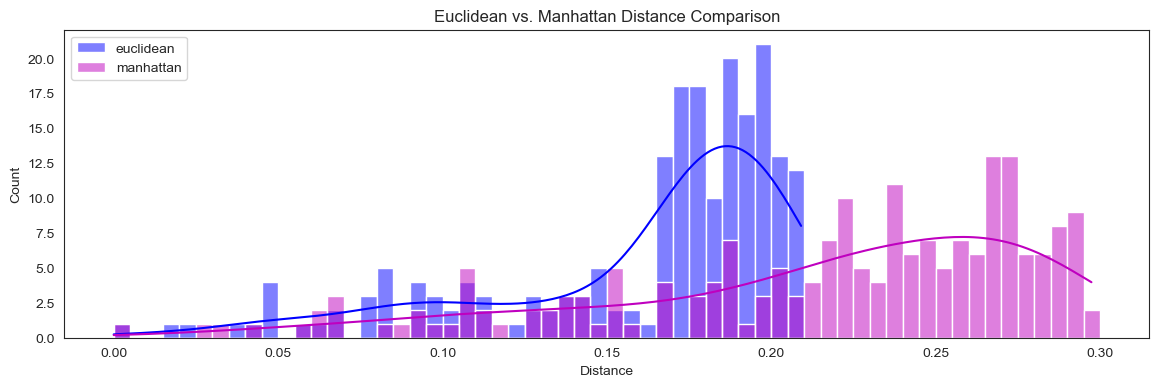

In [22]:
plt.figure(figsize=(14,4))
sns.set_style('white')
sns.histplot(euclidean,kde=True,color='b',alpha=0.5,label='euclidean',binwidth=0.005)
sns.histplot(manhattan,kde=True,color='m',alpha=0.5,label='manhattan',binwidth=0.005)
plt.title('Euclidean vs. Manhattan Distance Comparison')
plt.xlabel('Distance')
plt.legend(loc=2)
plt.show()

Based on the hypothesis test, the Manhattan distance tends to be larger than the Euclidean distance.

The nearest neighbors algorithm for the 1400th observation provides 5 same observations in unscaled data, while in scaled data, only the fourth and fifth observations differ. In Manhattan distance, the nearest observations are 1660 and 1557, while in Euclidean distance, they are 1557 and 1660.

## 6. Task 2 - Potential Insurance Claim Prediction <a id='class'></a>

In the context of machine learning, this task is similar to a binary classification task.

With the target variable insurance_benefits being greater than zero, let's evaluate whether the kNN classification model is a better approach than the dummy model.

* Create a KNN-based classifier and measure its quality using the F1 metric for k=1..10 for both the original and scaled data. It will be interesting to see how k affects the evaluation metric and whether data scaling makes a difference. Use the implementation of the kNN classification algorithm.
* Create a random dummy model for this case. The model should output "1" with some probability. Let's test the model with four probability values: 0, any probability of paying insurance benefit, 0.5, and 1.

The probability of paying an insurance claim can be defined as.

Dalam konteks *machine learning*, tugas ini sama seperti tugas klasifikasi biner.

$$
P\{\text{insurance claim received}\}=\frac{\text{number of clients receiving insurance claim}}{\text{total number of clients}}.
$$

Separate the entire data into a 70:30 ratio for the training and test sets.

In [23]:
# Calculate target
df['insurance_benefits_received'] = df['insurance_benefits'].apply(lambda x: 1 if x > 0 else 0)

In [24]:
# check class imbalance
df['insurance_benefits_received'].value_counts(normalize=True)

0    0.8872
1    0.1128
Name: insurance_benefits_received, dtype: float64

We can see that the class is imbalanced with 0 values make up to 88% of the entire dataset.

In [25]:
features = df[feature_names]
targets = df['insurance_benefits_received']

In [26]:
features_train, features_valid, targets_train, targets_valid = train_test_split(features,targets,test_size=0.3,random_state=state)

Next, we scale the features value with MaxAbsScaler.

In [27]:
scaler = sklearn.preprocessing.MaxAbsScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_valid_scaled = scaler.transform(features_valid)

In [28]:
def eval_classifier(y_true, y_pred):
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [29]:
# generate random binomial values
def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [30]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:
    print(f'Probability = {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size=features.shape[0], seed=42)
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    print()

Probability = 0.00
F1: 0.00
Confusion Matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

Probability = 0.11
F1: 0.12
Confusion Matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]

Probability = 0.50
F1: 0.20
Confusion Matrix
[[0.456  0.4312]
 [0.053  0.0598]]

Probability = 1.00
F1: 0.20
Confusion Matrix
[[0.     0.8872]
 [0.     0.1128]]



In [31]:
accuracy_scores = []
f1_scores = []
for k in range(1,11,1):
    model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k,metric='euclidean',algorithm='auto')
    model.fit(features_train_scaled, targets_train)
    predicted_valid = model.predict(features_valid_scaled)
    acc_score = sklearn.metrics.accuracy_score(targets_valid, predicted_valid)*100
    f1_score = sklearn.metrics.f1_score(targets_valid, predicted_valid)*100
    accuracy_scores.append(acc_score)
    f1_scores.append(f1_score)
    print(f'n_neighbors = {k}, Acc_score = {acc_score:.2f}%, F1_score = {f1_score:.2f}%')

n_neighbors = 1, Acc_score = 99.07%, F1_score = 95.36%
n_neighbors = 2, Acc_score = 98.53%, F1_score = 92.31%
n_neighbors = 3, Acc_score = 98.80%, F1_score = 93.92%
n_neighbors = 4, Acc_score = 98.00%, F1_score = 89.21%
n_neighbors = 5, Acc_score = 98.20%, F1_score = 90.59%
n_neighbors = 6, Acc_score = 97.87%, F1_score = 88.65%
n_neighbors = 7, Acc_score = 98.33%, F1_score = 91.41%
n_neighbors = 8, Acc_score = 98.00%, F1_score = 89.36%
n_neighbors = 9, Acc_score = 98.20%, F1_score = 90.66%
n_neighbors = 10, Acc_score = 98.07%, F1_score = 89.75%


In [32]:
df_temp = pd.DataFrame({'accuracy_scores': accuracy_scores, 'f1_scores' : f1_scores}, index=np.arange(1,11))
df_temp.index.name = 'n_neighbors'
df_temp

,accuracy_scores,f1_scores
n_neighbors,,
1,99.066667,95.364238
2,98.533333,92.307692
3,98.800000,93.918919
4,98.000000,89.208633
5,98.200000,90.592334
6,97.866667,88.652482
7,98.333333,91.408935
8,98.000000,89.361702
9,98.200000,90.657439


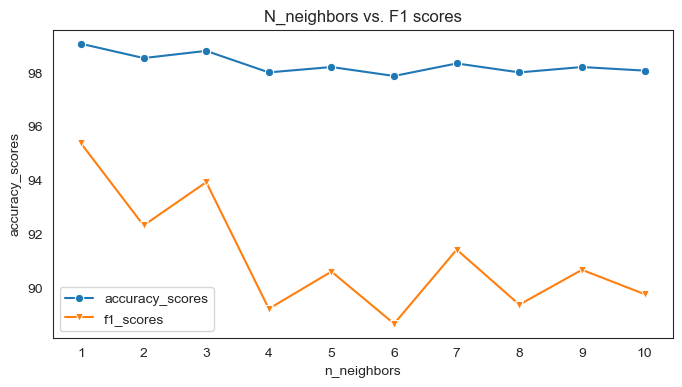

In [33]:
plt.figure(figsize=(8,4))
sns.lineplot(data=df_temp, x='n_neighbors', y='accuracy_scores', marker="o",label='accuracy_scores')
sns.lineplot(data=df_temp, x='n_neighbors', y='f1_scores', marker="v",label='f1_scores')
plt.title('N_neighbors vs. F1 scores')
plt.xticks(np.arange(1,11))
plt.legend()
plt.show()

The K-Neighbors-Classifier model is indeed better than the random dummy model. As the number of neighbors taken into consideration increases, the F1 score decreases, and the accuracy slightly decreases as well.

## 7. Task 3 - Insurance Benefit Regression <a id='reg'></a>

With `insurance_benefit` as the target, evaluate the RMSE for the Linear Regression model.

Create your own implementation of Linear Regression. For that, try to recall how the solution for the linear regression task is formulated in the form of linear algebra. Check the RMSE for both the original and scaled data. Can you observe any differences in RMSE between these two cases?

Show:
- $X$ — the feature matrix, where each row represents one case, each column represents a feature, and the first column consists of ones.
- $y$ — target vector
- $\hat{y}$ — estimated target vector
- $w$ — weight vektor

The matrix for linear regression can be formulated as:

$$
y = Xw
$$

The training objective is to find $w$ that minimizes the L2 distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{atau} \quad \min_w \text{MSE}(Xw, y)
$$

It seems that there is an analytical solution for the problem above:

$$
w = (X^T X)^{-1} X^T y
$$

The above formula can be used to find the weight $w$, and the latter can be used to calculate the predicted values:

$$
\hat{y} = X_{val}w
$$

Separate the entire data into a *training set* and a *validation set* with a 70:30 ratio. Use the RMSE metric for model evaluation.

In [34]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # menambahkan satuan
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        weights = np.linalg.inv(X2.T@X2)@X2.T@y
        self.weights = weights[1:]
        self.bias = weights[0]

    def predict(self, X):
        
        # menambahkan satuan
        X2 = np.append(np.ones([len(X), 1]), X, axis=1) 
        y_pred = X@self.weights + self.bias
        
        return y_pred

In [35]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [36]:
X = df_scaled[feature_names].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=state)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[ 3.95825279e-03  2.31177591e+00 -2.28239150e-04 -9.97045011e-02]
RMSE: 0.36
R2: 0.65


In [37]:
df_temp = pd.DataFrame()

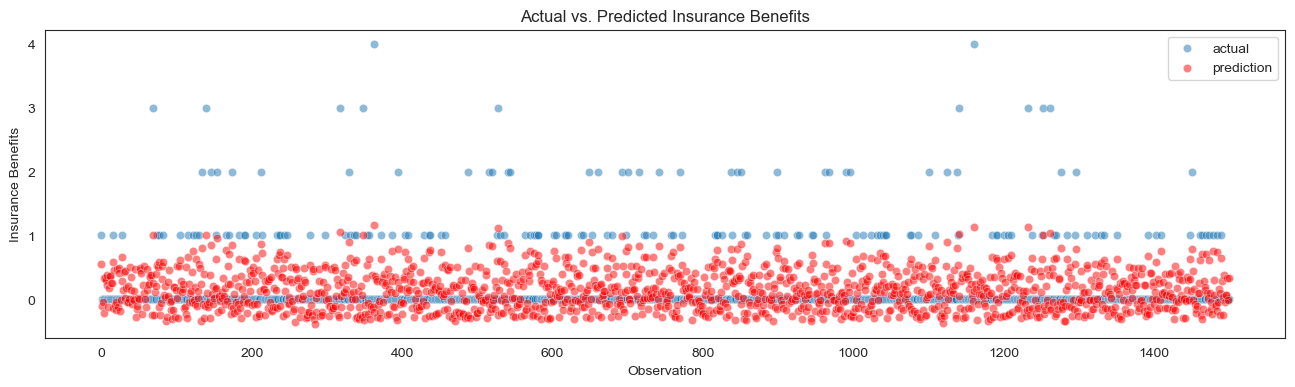

In [38]:
plt.figure(figsize=(16,4))
sns.scatterplot(y=y_test,x=np.arange(0,len(y_test)),alpha=0.5,label='actual')
sns.scatterplot(y=y_test_pred,x=np.arange(0,len(y_test)),color='r',alpha=0.5,label='prediction')
plt.title('Actual vs. Predicted Insurance Benefits')
plt.xlabel('Observation')
plt.ylabel('Insurance Benefits')
plt.legend()
plt.show()

In [39]:
y_test_pred_rounded = []
for y in y_test_pred:
    y_test_pred_rounded.append(round(y))
        
eval_regressor(y_test, y_test_pred_rounded)

RMSE: 0.29
R2: 0.78


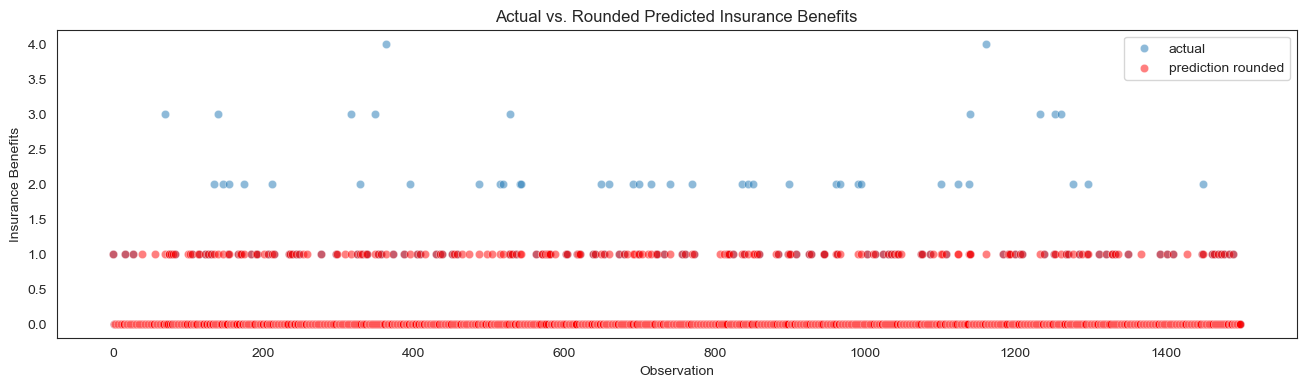

In [40]:
plt.figure(figsize=(16,4))
sns.scatterplot(y=y_test,x=np.arange(0,len(y_test)),alpha=0.5,label='actual')
sns.scatterplot(y=y_test_pred_rounded,x=np.arange(0,len(y_test)),color='r',alpha=0.5,label='prediction rounded')
plt.title('Actual vs. Rounded Predicted Insurance Benefits')
plt.xlabel('Observation')
plt.ylabel('Insurance Benefits')
plt.legend()
plt.show()

The linear regression model has RMSE of 0.35 and R2 score of 0.65. It is typically wrong by 0.35 in each prediction and only 65% variation in insurance benefit is explained by variation in its inputs. If the prediction from the linear regression is rounded to the nearest whole number, then the RMSE is 0.30 and R2 score is 0.75. This rounded values provide more accurate predictions.

## 8. Task 4 - Data Obfuscation <a id='mask'></a>

The best way to obfuscate data is by multiplying the numerical features (remember that these features can be seen in the matrix $X$) with a invertible matrix $P$. 

$$
X' = X \times P
$$

Try doing that and check how the feature values will look after the transformation. The invertible property is crucial in this case, so make sure that $P$ is invertible.

You may want to review the lesson 'Matrices and Matrix Operations -> Matrix Multiplication' to recall the rules of matrix multiplication and its implementation with NumPy.

In [41]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [42]:
X = df_pn.to_numpy()

Generating random matrix $P$.

In [43]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking is $P$ matrix invertible.

In [44]:
np.linalg.inv(P)

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

Yes, matrix P is invertible.

In [45]:
X_inv = X @ P

In [46]:
obs_df = pd.DataFrame(X_inv, columns=personal_info_column_list)
obs_df.head()

,gender,age,income,family_members
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631
3,5345.603937,18803.227203,15479.148373,38663.061863
4,3347.176735,11782.829283,9699.998942,24211.273378


Can you guess the age of the clients or their income after the transformation?

No, it is not possible to guess the age or income of the clients after the transformation because the transformation process obfuscates the original data.

Can you recover the original data from $X'$ if $P$ is known? Try checking this through calculations by moving $P$ from the right side of the formula above to the left side. The rules of matrix multiplication are very useful here.

In [47]:
X_inv_inv = X_inv @ np.linalg.inv(P)

In [48]:
rec_df = pd.DataFrame(X_inv_inv, columns=personal_info_column_list)
rec_df

,gender,age,income,family_members
0,1.000000e+00,41.0,49600.0,1.000000e+00
1,-4.473636e-12,46.0,38000.0,1.000000e+00
2,-2.515869e-12,29.0,21000.0,9.524523e-13
3,-4.844982e-12,21.0,41700.0,2.000000e+00
4,1.000000e+00,28.0,26100.0,-1.019907e-13
...,...,...,...,...
4995,-2.559766e-12,28.0,35700.0,2.000000e+00
4996,-5.486091e-12,34.0,52400.0,1.000000e+00
4997,-1.928379e-12,20.0,33900.0,2.000000e+00
4998,1.000000e+00,22.0,32700.0,3.000000e+00


Show the three cases for several clients:
- Original Data
- Transformed Data
- Recovered Data

Original Data:

In [49]:
df[personal_info_column_list].head()

,gender,age,income,family_members
0,1,41,49600,1
1,0,46,38000,1
2,0,29,21000,0
3,0,21,41700,2
4,1,28,26100,0


Obfuscated Data:

In [50]:
obs_df.head()

,gender,age,income,family_members
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631
3,5345.603937,18803.227203,15479.148373,38663.061863
4,3347.176735,11782.829283,9699.998942,24211.273378


Recovered Data:

In [51]:
rec_df.head()

,gender,age,income,family_members
0,1.000000e+00,41.0,49600.0,1.000000e+00
1,-4.473636e-12,46.0,38000.0,1.000000e+00
2,-2.515869e-12,29.0,21000.0,9.524523e-13
3,-4.844982e-12,21.0,41700.0,2.000000e+00
4,1.000000e+00,28.0,26100.0,-1.019907e-13


You may notice that there are some values that are not exactly the same as the data before the transformation. Why is that?

The values obtained from the inverse transformation are very similar to the values in the original dataset. The only difference is in the number 0, which is likely treated as a very small number before the multiplication, resulting in slightly different values.

## 9. Proof That Linear Regression Can Work With Obfuscated Data <a id='mask1'></a>

The regression task in this project has been completed using linear regression. The next task is to analytically prove that a specific data obfuscation method will not affect the prediction of linear regression values - the predicted values will not change from the original results. Are you confident that you can do it? You don't have to be confident right now, but you need to prove it!

So, the existing data has been obfuscated and now we have $X \times P$ instead of just $X$. As a result, there is another weight $w_P$ given by 

$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How can we relate $w$ and $w_P$ if we simplify the formula for $w_P$ above?

What values will $w_P$ predict?

What does it mean for the quality of linear regression when measured with RMSE?

**Answer**

Yes, we can.

**Analytical Proof**

$
w_P = [(XP)^T XP]^{-1} (XP)^T y
$

$
w_P = [P^T X^T XP]^{-1} (P^T X^T) y
$

$
w_P = P^{-1} X^{-1} X^{T-1} P^{T-1} P^T X^T y
$

$
w_P = P^{-1} X^{-1} X^{T-1} I X^T y
$

$
w_P = P^{-1} (X^T X)^{-1} X^T y
$

$
w_P = P^{-1} w
$

Because $y=Xw$, then $y_p=X_p w_p=XPP^{-1}w=Xw=y$

Therefore we can predict y using the obfuscated data.

## 10. Testing Linear Regression With Obfuscated Data <a id='mask2'></a>

Now, let's prove that Linear Regression can work computationally with the selected data obfuscation transformation.

Create a procedure or class that performs linear regression with data obfuscation. You can use the linear regression available in scikit-learn or your own implementation.

Run linear regression on the original data and the obfuscated data, compare the prediction values and RMSE, as well as the $R^2$ metric. Is there any difference?

Procedure:
* Create a square matrix $P$ with random numbers.
* Check if the matrix is invertible. If not, repeat from step 1 until we obtain an invertible matrix.
* Use $XP$ as the new feature matrix.

In [52]:
rng = np.random.default_rng(seed=0)
P = rng.random(size=(df[personal_info_column_list].shape[1],df[personal_info_column_list].shape[1]))

In [53]:
X = df_scaled[personal_info_column_list].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

In [54]:
X_obs = X @ P

In [55]:
X_obs_train, X_obs_test, y_train, y_test = train_test_split(X_obs, y, test_size=0.3,random_state=state)

In [56]:
np.linalg.inv(P)

array([[ 1.49191502, -0.12420986, -0.32286796,  0.38050028],
       [ 0.47809328,  0.23884461,  0.73600764, -1.04837879],
       [-1.53876315, -0.19559101,  0.60084696,  0.94770473],
       [-0.98183275,  1.37308658, -1.06061012,  0.09945549]])

In [57]:
lr = MyLinearRegression()

lr.fit(X_obs_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_obs_test)
eval_regressor(y_test, y_test_pred)

[-0.29025726  0.63434928 -0.57585145  3.20644694]
RMSE: 0.34
R2: 0.65


According to the analytical proof, the RMSE and R2 values obtained from linear regression with data obfuscation are the same as those obtained from linear regression without data obfuscation.

## 11. General Conclusion <a id='end'></a>

Based on EDA, we found that older customers have more insurance benefits than younger customers. We get significantly **different** results using scaled and unscaled values. In unscaled data, **larger values have bigger weights** which makes the nearest neighbors calculation biased towards variables with larger values. Regardless of data scaling, Manhattan distance typically is larger than Euclidean distance.

Prediction using KNN Classifier results in **better** predictions than dummy model. The F1 score using KNN Classifier reaches **99%** whereas dummy model only has **20%** F1 score. Prediction using linear regression model has **RMSE of 0.35** and **R2 score of 0.65**. If the prediction from the linear regression is **rounded** to the nearest whole number, then the **RMSE is 0.30** and **R2 score is 0.75**.

Data obfuscation is conducted by multiplying dataset with random invertible matrix. This procedure is conducted to prevent data leaking. This obfuscated data **can** be converted back to the original data as long as we remember the corresponding invertible matrix. The obfuscated data can also be used to predict response variable. It gives the **same** result as the prediction using non-obfuscated data.

## 12. Appendix <a id='index'></a>

### Matrix Properties

<table>
<tr>
<td>Distribution</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutability</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Identity Multiplication</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversibility of matrix product tranposition</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>